# AuTextification

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings

# Suppress FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning)

Skip the preprocess (faster)

In [2]:
root = './data/competition_2024/new_preprocessed_data_subtask1/'
faster = False

if faster:
    train_en_preprocessed = pd.read_csv(root+'train_en_preprocessed.csv')
    train_es_preprocessed = pd.read_csv(root+'train_es_preprocessed.csv')
    train_ca_preprocessed = pd.read_csv(root+'train_ca_preprocessed.csv')
    train_pt_preprocessed = pd.read_csv(root+'train_pt_preprocessed.csv')
    train_eu_preprocessed = pd.read_csv(root+'train_eu_preprocessed.csv')
    train_gl_preprocessed = pd.read_csv(root+'train_gl_preprocessed.csv')

    train_preprocessed = pd.read_csv(root+'train_preprocessed.csv')

# Preprocess

## Data

In [3]:
train = pd.read_csv('C:/Users/34686/3CD - 23_24/PROY III/autextification/data_24/subtask1.csv').drop(columns='Unnamed: 0')
train.head()

,id,text,label
0,15442,Es un tribunal de suprema instanza que forma p...,generated
1,26409,Aixó de tindrer la platgeta tant prou era un p...,human
2,12777,Doug mcadam es un científico estadista estadou...,generated
3,63467,"El president de la generalitat, carles puigdem...",generated
4,41050,"Traídas de francia, tan estrafalarias que una ...",generated


## Identifying languages

* English (en)
* Spanish (es)
* Portuguese (pt)
* Galician (gl)
* Basque (eu)
* Catalan (ca)

https://www.toolify.ai/es/ai-news-es/7-herramientas-nlp-para-deteccin-de-idioma-en-python-1143843

### Identification with different libreries

#### Lang id

In [4]:
#### Lang id
from py3langid.langid import LanguageIdentifier, MODEL_FILE

identifier = LanguageIdentifier.from_pickled_model(MODEL_FILE)
identifier.set_languages(['en', 'es', 'pt', 'gl', 'eu', 'ca'])
identifier.classify(train.loc[0, 'text'])

def language_detector_lingua_langid(text):
    return identifier.classify(text)[0]


#### Lang detect (not worth it)

In [5]:
#### Langdetect
from langdetect import detect  # pip install langdetect
from langdetect import detect_langs

# train['text'][:100].apply(detect)
# train['text'][:100]

#### Fasttext

In [6]:
import fasttext
model_path = 'modules/lan_id/lid.176.bin'  # ruta al modelo pre-entrenado
model = fasttext.load_model(model_path)

def language_detector_fasttext_all(text):
    predicted_languages = model.predict(text)
    language_code = predicted_languages[0][0].replace('__label__', '')
    return language_code


In [7]:
import fasttext

model_path = 'modules/lan_id/lid.176.bin'  # ruta al modelo pre-entrenado
model = fasttext.load_model(model_path)

allowed_languages = ['ca', 'es', 'en', 'eu', 'pt', 'gl']

def language_detector_fasttext(text):
    predicted_languages, probabilities = model.predict(text, k=-1)  
    for language, probability in zip(predicted_languages, probabilities):
        language_code = language.replace('__label__', '')
        if language_code in allowed_languages:
            return language_code
    return None  # if language not in allowed


#### Lingua (doesn't include gl)

In [8]:
#### Lingua
from scipy.sparse import csr_matrix
# from lingua import Language, LanguageDetectorBuilder
from sklearn.metrics import confusion_matrix


def language_detector_lingua(text):
    language = detector.detect_language_of(text)
    if language == Language.CATALAN:
        return 'ca'
    elif language == Language.SPANISH:
        return 'es'
    elif language == Language.BASQUE:
        return 'eu'
    elif language == Language.PORTUGUESE:
        return 'pt'
    elif language == Language.ENGLISH:
        return 'en'


In [9]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def check_with_lingua(df=train, remove=False):
    
    df['lang_detected:langid'] = df['text'].apply(language_detector_lingua_langid)
    df['lang_detected:lingua'] = df['text'].apply(language_detector_lingua)

    languages_detected = sorted(df['lang_detected:langid'].unique())
    languages_check = sorted(df['clang_detected:lingua'].unique())
    languages = sorted(set(languages_detected + languages_check))  # Unir idiomas únicos

    conf_matrix = confusion_matrix(df['lang_detected:lingua'], df['lang_detected:langid'], labels=languages)
    df['pred_correct'] = df['lang_detected:lingua'] == df['lang_detected:langid']


    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=languages, yticklabels=languages)
    plt.xlabel('Langid')
    plt.ylabel('Lingua')
    plt.title('Confusion matrix')
    plt.show()
    
    if remove: # Remove missclassifications

        incorrect = df.loc[df['pred_correct'] == False]
        mix_languages = incorrect.loc[incorrect['detected_language'] != 'gl']
        filas_borrar = mix_languages.index
        df.drop(filas_borrar, axis=0, inplace=False)



### Aplication

In [10]:
## Lang id
train['lang_detected:langid'] = train['text'].apply(language_detector_lingua_langid)


In [11]:
## Fasttext mix of languages
train['lang_detected:all_fasttext'] = train['text'].apply(language_detector_fasttext_all)
train[train["lang_detected:langid"] != train["lang_detected:all_fasttext"]] # 1611 con mezcla de textos

,id,text,label,lang_detected:langid,lang_detected:all_fasttext
135,130237,#bieberfever #justinbieber #belieber #purpose ...,generated,es,en
210,103681,Pó só e pan ralado deu só e água que tá nascen...,generated,gl,pt
315,134694,Acontecementos pilemenes ii sucede a pilemenes...,human,es,gl
372,110951,Morro cabeça no tempo brasilgo udalerri bat da...,human,pt,eu
401,47888,@vilarcapella ja hem tornat: pericos 3 - jupit...,human,ca,sv
...,...,...,...,...,...
109320,127651,"E m""encanta aquesta cançó! sempre que la sento...",generated,pt,ca
109478,68269,Adoro o facto de ñ conseguir tirar mais ningué...,human,gl,pt
109504,149412,"Simplemente, agradecerche que esteas ahí día a...",human,es,gl
109518,11249,@topstockoutlet ¿deseas renovar tu tienda o in...,generated,gl,es


In [12]:
## Fasttext Bad classified
train['lang_detected:fasttext'] = train['text'].apply(language_detector_fasttext)
train[train["lang_detected:langid"] != train["lang_detected:fasttext"]] # 1611 con mezcla de textos

,id,text,label,lang_detected:langid,lang_detected:all_fasttext,lang_detected:fasttext
135,130237,#bieberfever #justinbieber #belieber #purpose ...,generated,es,en,en
210,103681,Pó só e pan ralado deu só e água que tá nascen...,generated,gl,pt,pt
315,134694,Acontecementos pilemenes ii sucede a pilemenes...,human,es,gl,gl
372,110951,Morro cabeça no tempo brasilgo udalerri bat da...,human,pt,eu,eu
552,133529,¡wow! ¡qué manera de exagerar! cristiano ronal...,generated,pt,es,es
...,...,...,...,...,...,...
109320,127651,"E m""encanta aquesta cançó! sempre que la sento...",generated,pt,ca,ca
109478,68269,Adoro o facto de ñ conseguir tirar mais ningué...,human,gl,pt,pt
109504,149412,"Simplemente, agradecerche que esteas ahí día a...",human,es,gl,gl
109518,11249,@topstockoutlet ¿deseas renovar tu tienda o in...,generated,gl,es,es


In [13]:
for i, row in train[train["lang_detected:langid"] != train["lang_detected:fasttext"]].iterrows():
    print(f'Row nº {i}')
    print(f'Text: {row.text[:50]}')
    print(f'Langid: {row["lang_detected:langid"]}')
    print(f'Fasttext: {row["lang_detected:fasttext"]}')
    print()


Row nº 135
Text: #bieberfever #justinbieber #belieber #purpose #lov
Langid: es
Fasttext: en

Row nº 210
Text: Pó só e pan ralado deu só e água que tá nascendo q
Langid: gl
Fasttext: pt

Row nº 315
Text: Acontecementos pilemenes ii sucede a pilemenes i n
Langid: es
Fasttext: gl

Row nº 372
Text: Morro cabeça no tempo brasilgo udalerri bat da, pi
Langid: pt
Fasttext: eu

Row nº 552
Text: ¡wow! ¡qué manera de exagerar! cristiano ronaldo n
Langid: pt
Fasttext: es

Row nº 582
Text: Galician news article: italianos desanimados tras 
Langid: gl
Fasttext: es

Row nº 605
Text: Puigdemont reprend une paroles de rajoy pour défen
Langid: en
Fasttext: ca

Row nº 799
Text: ¡oh, señor!, ¡oh, rey!, ¡oh, amo!, ¡oh, amado!, ¡o
Langid: gl
Fasttext: es

Row nº 993
Text: Fons salutaris, llibertat, lluny, és la meva alma 
Langid: en
Fasttext: ca

Row nº 1207
Text: @vivi_l_crawford @victoriajustice @dylanobrien dif
Langid: es
Fasttext: pt

Row nº 1429
Text: Músico e compositor uruguaio, natural de montevidé


Fasttext: pt

Row nº 26732
Text: Esta canción me recuerda os meus veranos na galici
Langid: gl
Fasttext: pt

Row nº 26875
Text: Acr gulpilhares é un clube de futebol da parroquia
Langid: gl
Fasttext: pt

Row nº 26917
Text: A ucrânia passou por uma semana que abriu as porta
Langid: en
Fasttext: pt

Row nº 26988
Text: @3gerardpique @fotlipou que bons que sou! m"ho he 
Langid: ca
Fasttext: es

Row nº 27059
Text: @danirobertl_87 @marc_sag80 @premipfcat @barcelona
Langid: ca
Fasttext: es

Row nº 27075
Text: Grandes minutos dos nosos que estan a facer un gra
Langid: gl
Fasttext: es

Row nº 27171
Text: Vistes, madr", o que dizía que o meu amor era ment
Langid: gl
Fasttext: pt

Row nº 27179
Text: Prepárense en #girona para un fenómeno costero de 
Langid: gl
Fasttext: es

Row nº 27180
Text: La seva amistat és solida com les barres de sanch 
Langid: en
Fasttext: ca

Row nº 27181
Text: Gostaria de saber se serve para auto novel porque 
Langid: gl
Fasttext: pt

Row nº 27256
Text: Não sinto mais aq

Text: ¡buenísima tarde! ¿qué planes tenéis para hoy? si 
Langid: pt
Fasttext: es

Row nº 50269
Text: @nigger94 et @felixmm91, no s"ho esperava que @daa
Langid: pt
Fasttext: es

Row nº 50554
Text: El plus repeteix el penal a cristiano i no el gol
Langid: es
Fasttext: ca

Row nº 50659
Text: Marabillosos diálogos que me fan repensar sobre o 
Langid: pt
Fasttext: es

Row nº 50875
Text: Eu, ó de ocultar a última conexión de whatsapp, ve
Langid: es
Fasttext: gl

Row nº 50946
Text: Bothrops neuwiedi bothrops generoko animalia da. n
Langid: en
Fasttext: eu

Row nº 51069
Text: Cando o sol lostreguee tral-a outra(1) montana col
Langid: gl
Fasttext: pt

Row nº 51072
Text: Canto custa ser atractivo! non o digo eu, dígoo @i
Langid: gl
Fasttext: pt

Row nº 51129
Text: A tumba do soldado descoñecido é o nome que recibe
Langid: es
Fasttext: gl

Row nº 51178
Text: @iriatenreiro4: el que no ame a poroto lux no enti
Langid: gl
Fasttext: es

Row nº 51252
Text: Muito boa, prazo de entrega minimo, produto d

Fasttext: pt

Row nº 78841
Text: Non posso crerd que hable de #joer e non mencionar
Langid: gl
Fasttext: pt

Row nº 78911
Text: ¡hola @victorruiz_c @ernestalenya! no crec que sig
Langid: ca
Fasttext: es

Row nº 79041
Text: A segunda colonia máis numerosa de gatos abandoado
Langid: es
Fasttext: gl

Row nº 79191
Text: Chove, de xionllos, chove. cantiga d"a boa dor. a 
Langid: gl
Fasttext: pt

Row nº 79201
Text: Xa vai chegar o qué, non o qué? o qué, non o qué? 
Langid: gl
Fasttext: pt

Row nº 79207
Text: I parlo de la meva vila, no de barna. molt bona ob
Langid: es
Fasttext: ca

Row nº 79263
Text: Sure, here is a poem in catalan about the legend o
Langid: en
Fasttext: ca

Row nº 79280
Text: Os miños dos 1º e 2º curso de infantxe acabaron de
Langid: gl
Fasttext: es

Row nº 79282
Text: Coelorinchus goobala és una espècie de peix de la 
Langid: en
Fasttext: ca

Row nº 79310
Text: "we want it all" songs and artists that inspired f
Langid: en
Fasttext: eu

Row nº 79494
Text: ". a rúa de clara

Langid: en
Fasttext: eu

Row nº 101893
Text: Hor irekia dagoen posturako konpostaz erabiliz dit
Langid: en
Fasttext: eu

Row nº 101998
Text: ¡què feliç em fa veure que em vulguis tant! t"esti
Langid: pt
Fasttext: ca

Row nº 102148
Text: Zuzen ere, harri hori zer da? hilerri bat dirudi h
Langid: en
Fasttext: eu

Row nº 102239
Text: A barquiña ("the little boat" or "the dinghy") is 
Langid: gl
Fasttext: pt

Row nº 102393
Text: Os profundos (the deep ones, no inglés orixinal) s
Langid: es
Fasttext: gl

Row nº 102586
Text: Serra brasilgo udalerri bat da, espírito santo est
Langid: gl
Fasttext: eu

Row nº 102626
Text: Márcio rodrigues araújo (1984ko ekainaren 11 - ) b
Langid: es
Fasttext: eu

Row nº 102722
Text: , que en breve entro na serra quen sabe que entro 
Langid: gl
Fasttext: pt

Row nº 102739
Text: Rra volta, mais as turmas conversa, audaz e miazos
Langid: gl
Fasttext: pt

Row nº 102803
Text: Ostrou a pouca sazon a un prest", e disse-ll" ento
Langid: gl
Fasttext: pt

Row nº 102815
T

In [14]:
train[train['lang_detected:fasttext'] != train['lang_detected:all_fasttext']]

,id,text,label,lang_detected:langid,lang_detected:all_fasttext,lang_detected:fasttext
401,47888,@vilarcapella ja hem tornat: pericos 3 - jupit...,human,ca,sv,ca
1059,59322,"Hi ha gent q em diu ""vigila q et copien la ide...",human,ca,it,ca
3171,11833,"So beau has a girlfriend she""s so (beau)tiful ...",human,en,de,en
7087,110780,¡ja! kontu honetan @aiora9 eta @goiatz96 bater...,generated,eu,eo,eu
8180,57042,I miss being a child~ (punta cana) #puntacana ...,human,en,ceb,en
...,...,...,...,...,...,...
101931,100658,"Bon vespre! si us plau, callat-vos ho sentim, ...",generated,ca,it,ca
103127,133476,Borgore & sikdope - unicorn zombie apocalypse ...,human,en,fr,en
103387,72046,@justinbieber #justinmeetmaialen be4 i die rt ...,generated,en,de,en
109187,111876,Zelan aspaldiko ikusten degu lan da lan zabize...,generated,eu,br,eu


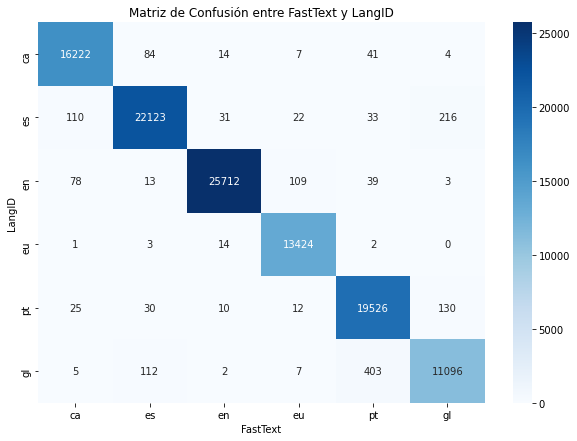

In [15]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(train['lang_detected:langid'], train['lang_detected:fasttext'], labels=['ca', 'es', 'en', 'eu', 'pt', 'gl'])
conf_matrix_df = pd.DataFrame(conf_matrix, index=['ca', 'es', 'en', 'eu', 'pt', 'gl'], columns=['ca', 'es', 'en', 'eu', 'pt', 'gl'])

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('FastText')
plt.ylabel('LangID')
plt.title('Matriz de Confusión entre FastText y LangID')
plt.show()

In [16]:
# We just keep the rows whose language is the same in the 3 classifications
train = train[(train['lang_detected:fasttext'] == train['lang_detected:langid']) & 
              (train['lang_detected:fasttext'] == train['lang_detected:all_fasttext'])]


In [17]:
train.rename(columns={'lang_detected:langid': 'detected_language'}, inplace=True)


<ipython-input-17-3e95a014fb55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'lang_detected:langid': 'detected_language'}, inplace=True)


### Checking

#### Some stats

In [18]:
train['label'].value_counts()
train['detected_language'].value_counts()

detected_language
en    25702
es    22119
pt    19522
ca    16195
eu    13419
gl    11095
Name: count, dtype: int64

In [19]:
train['label'].value_counts()

label
generated    57880
human        50172
Name: count, dtype: int64

In [20]:
total = 57880 + 50909
50909/total

0.46796091516605537

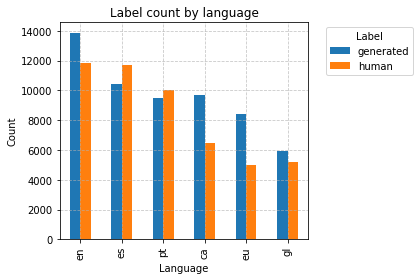

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

train_grouped = train.groupby('detected_language')['label'].value_counts().unstack().fillna(0)
train_grouped = train_grouped.loc[train_grouped.sum(axis=1).sort_values(ascending=False).index]

ax = train_grouped.plot(kind='bar', stacked=False)
plt.xlabel('Language')
plt.ylabel('Count')

plt.title('Label count by language')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7) 
plt.tight_layout()                         # Adding style
plt.show()

In [22]:
train_en = train[train['detected_language'] == 'en']
train_es = train[train['detected_language'] == 'es']
train_pt = train[train['detected_language'] == 'pt']
train_gl = train[train['detected_language'] == 'gl']
train_eu = train[train['detected_language'] == 'eu']
train_ca = train[train['detected_language'] == 'ca']

#### Sampling

In [23]:

# Dictionary to store samples for each language
samples_by_language = {}

# Number of samples per language
samples_per_language = 10

# Iterate over each language and select random samples
for language in train['detected_language'].unique():
    language_samples = train[train['detected_language'] == language].sample(samples_per_language)
    samples_by_language[language] = language_samples

# Concatenate the sampled dataframes
sample_df = pd.concat(samples_by_language.values())

sample_df

,id,text,label,detected_language,lang_detected:all_fasttext,lang_detected:fasttext
59520,147514,"""no em sembla gens bé que l""organització de l""...",generated,ca,ca,ca
75571,102961,"L""expresident del govern espanyol josé maría a...",human,ca,ca,ca
88039,36817,Este restaurant és una joia per a qualsevol am...,generated,ca,ca,ca
25054,108001,"Psychoda solivaga és una espècie d""insecte díp...",human,ca,ca,ca
2639,40838,""""""" artícul de wikipedia amb el títol ""imperme...",generated,ca,ca,ca
16619,18288,La costa brava ja fa olor de primavera. dissab...,human,ca,ca,ca
58013,80028,Units per avançar ha celebrat que la reforma d...,human,ca,ca,ca
641,110897,Este restaurant és una autèntica joia per a qu...,generated,ca,ca,ca
33854,28845,"El confinament del segrià ""no té data final"" p...",generated,ca,ca,ca
24283,130012,Un mapa temàtic és un mapa basat que transmet ...,human,ca,ca,ca


In [24]:
root = './data/competition_2024/data_lang_identified/'
save = False
if save:

    train_en.to_csv(root+'train_en.csv')
    train_es.to_csv(root+'train_es.csv')
    train_ca.to_csv(root+'train_ca.csv')
    train_pt.to_csv(root+'train_pt.csv')
    train_eu.to_csv(root+'train_eu.csv')
    train_gl.to_csv(root+'train_gl.csv')

    train.to_csv(root+'train.csv')

## Preprocess data

In [25]:
# Galician stop words --> https://github.com/Xangis/extra-stopwords/blob/master/galician
with open('./data/stop words/stopwords_galician.txt', 'r') as file:
    stopwords_galician_1 = [line.strip() for line in file.readlines()]
    stopwords_galician_1 = set(stopwords_galician_1)


In [26]:
# https://github.com/stopwords-iso/stopwords-gl/blob/master/stopwords-gl.txt
with open('data/stop words/stopwords-gl.txt', 'r') as file:
    stopwords_galician_2 = [line.strip() for line in file.readlines()]
    stopwords_galician_2 = set(stopwords_galician_2)

In [27]:
from nltk.corpus import stopwords

sw_en = set(stopwords.words('english'))
sw_es = set(stopwords.words('spanish'))
sw_pt = set(stopwords.words('portuguese'))
sw_ca = set(stopwords.words('catalan'))
sw_eu = set(stopwords.words('basque'))
sw_gl = stopwords_galician_1|stopwords_galician_2

In [28]:
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def text_process(mess, STOPWORDS):
    """
    Takes in a string of text and the stopwords, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a string of the cleaned text
    """
    # Remove punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # Remove stop words
    nostop = ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS and word.isalnum()])
    
    return nostop

# Asegúrate de tener descargadas las stopwords
# import nltk
# nltk.download('stopwords')

def preprocessing(df, STOPWORDS):
    # processing text
    df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))

    # calculate text length
    df['text_len'] = df['clean_text'].apply(len)
    
    # crop unnecessary columns
    df = df.drop(columns=['text', 'detected_language'])

    # map labels
    df['label'] = df['label'].map({'human': 0, 'generated': 1})

    return df


In [29]:
train_en_preprocessed = preprocessing(train_en, sw_en)

<ipython-input-28-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-28-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [30]:
train_es_preprocessed = preprocessing(train_es, sw_es)

<ipython-input-28-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-28-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [31]:
train_pt_preprocessed = preprocessing(train_pt, sw_pt)

<ipython-input-28-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-28-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [32]:
train_ca_preprocessed = preprocessing(train_ca, sw_ca)

<ipython-input-28-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-28-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [33]:
train_eu_preprocessed = preprocessing(train_eu, sw_eu)

<ipython-input-28-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-28-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [34]:
train_gl_preprocessed = preprocessing(train_gl, sw_gl)

<ipython-input-28-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-28-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [35]:
train_preprocessed = pd.concat([train_gl_preprocessed, train_ca_preprocessed, train_pt_preprocessed, train_eu_preprocessed, train_es_preprocessed, train_en_preprocessed])
train_preprocessed

,id,label,lang_detected:all_fasttext,lang_detected:fasttext,clean_text,text_len
5,91814,1,gl,gl,saída trives baiona será ás 8 30h mañá praza c...,211
17,140701,0,gl,gl,illas columbretes son conxunto catro grupos il...,1361
29,39136,0,gl,gl,bioloxía evolutiva desenvolvemento tamén evolu...,2287
32,95882,0,gl,gl,todos sindicatos presentes reunión rexeitamos ...,1370
34,62806,1,gl,gl,300 novela gráfica é obra arte ficción escrito...,452
...,...,...,...,...,...,...
109643,94952,0,en,en,rtion every little however one dog another wou...,836
109647,1078,0,en,en,mark xvii mark 17 often refers 17th version pr...,781
109654,122155,1,en,en,marianne recovered injury changed woman gone l...,1246
109660,144741,1,en,en,irish president signed longawaiting mother bab...,1548


In [36]:
root = './data/competition_2024/new_preprocessed_data_subtask1/'

save= False
if save:
    train_en_preprocessed.to_csv(root+'train_en_preprocessed.csv')
    train_es_preprocessed.to_csv(root+'train_es_preprocessed.csv')
    train_ca_preprocessed.to_csv(root+'train_ca_preprocessed.csv')
    train_pt_preprocessed.to_csv(root+'train_pt_preprocessed.csv')
    train_eu_preprocessed.to_csv(root+'train_eu_preprocessed.csv')
    train_gl_preprocessed.to_csv(root+'train_gl_preprocessed.csv')

    train_preprocessed.to_csv(root+'train_preprocessed.csv')


## Exploration

### Plot length

In [37]:

def plot_length(corpus, lan):
    
    plt.figure(figsize=(12, 8))

    corpus[corpus.label == 0].text_len.plot(bins=35, kind='hist', color='blue', 
                                           label='Human texts', alpha=0.5)
    corpus[corpus.label == 1].text_len.plot(bins=35, kind='hist', color='red', 
                                           label='Generated texts', alpha=0.5)
    plt.xlabel("Message Length")
    plt.title(f'Texts length for {lan} language')
    plt.legend(title='Texts', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.savefig(f'Texts length for {lan} language.png')

    plt.show()
    print(f"{lan} -> Average Human text length: {corpus[corpus.label == 0]['text_len'].mean()}")
    print(f"{lan} -> Average Computer text length: {corpus[corpus.label == 1]['text_len'].mean()}")
    print()
    


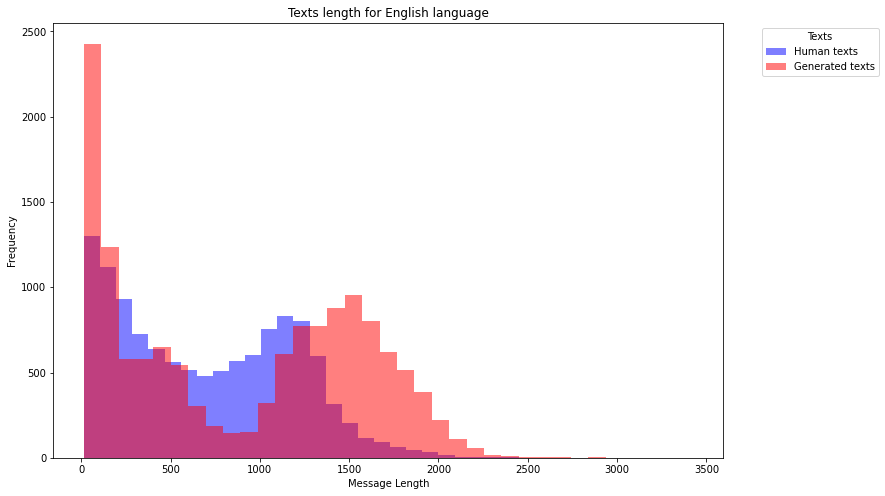

English -> Average Human text length: 705.1453562072171
English -> Average Computer text length: 906.1506957963804



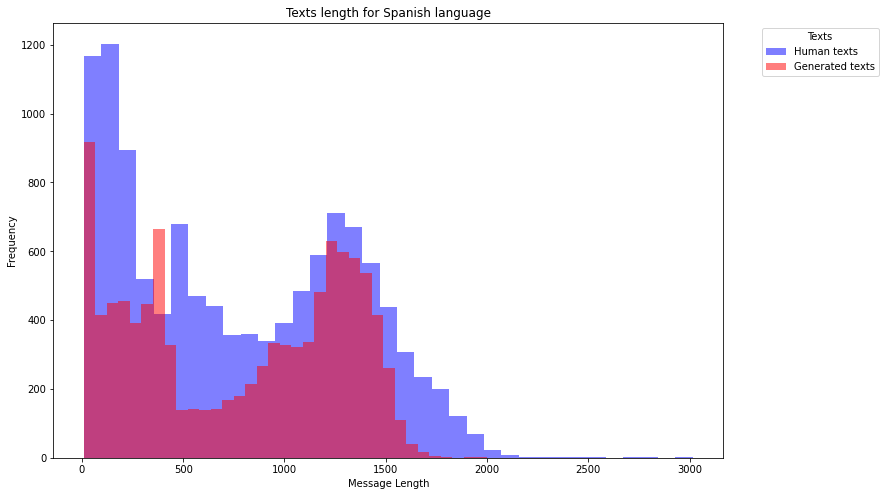

Spanish -> Average Human text length: 778.1787183002057
Spanish -> Average Computer text length: 782.6038097061357



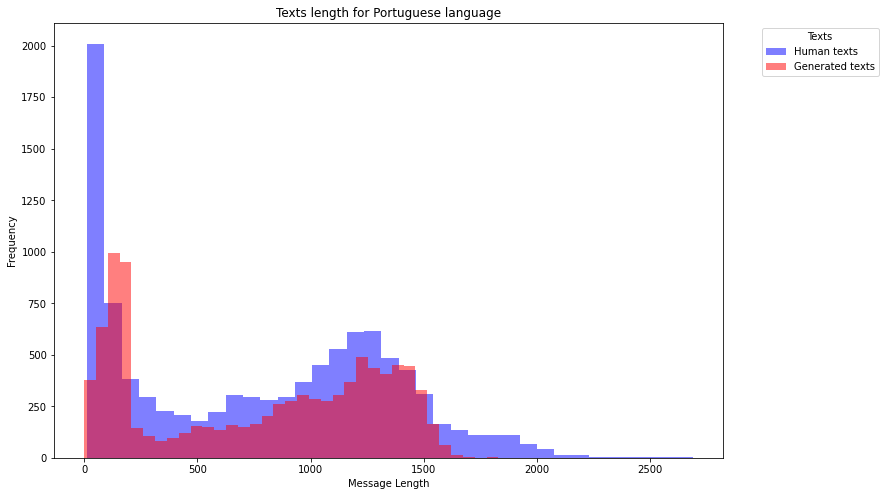

Portuguese -> Average Human text length: 770.4192775893035
Portuguese -> Average Computer text length: 764.6238947368421



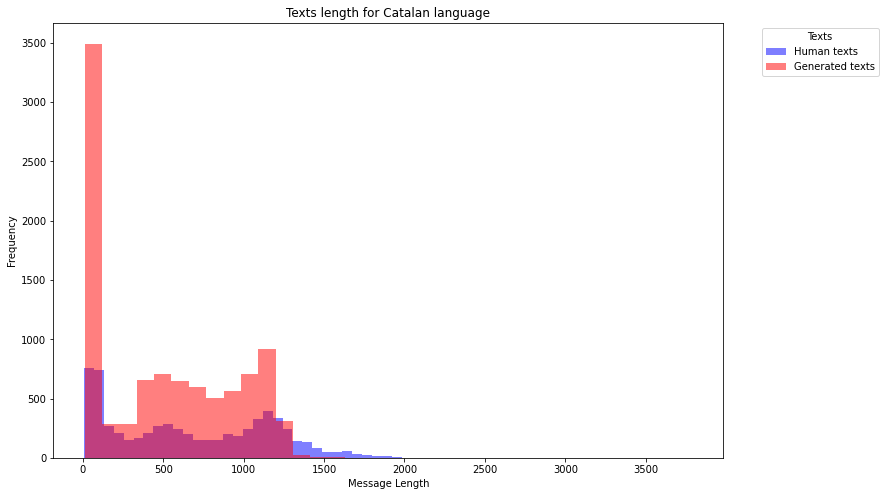

Catalan -> Average Human text length: 665.664402593393
Catalan -> Average Computer text length: 505.54245137388085



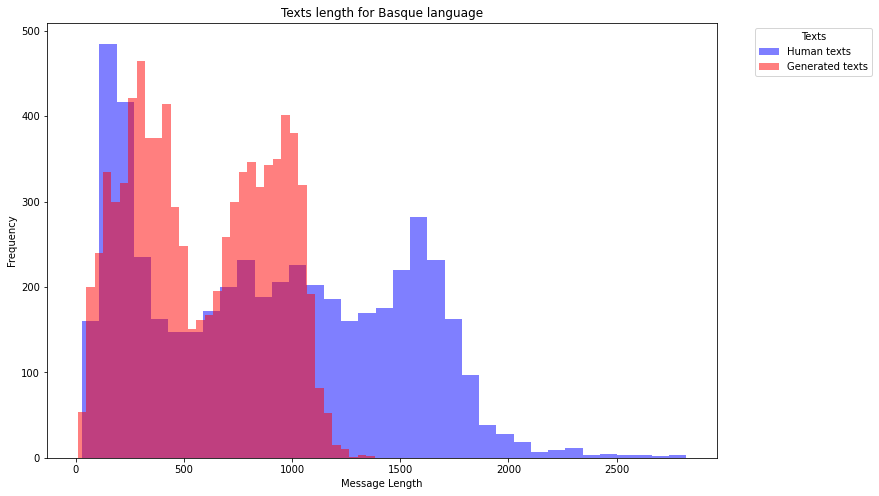

Basque -> Average Human text length: 902.5512409927942
Basque -> Average Computer text length: 584.1787961533895



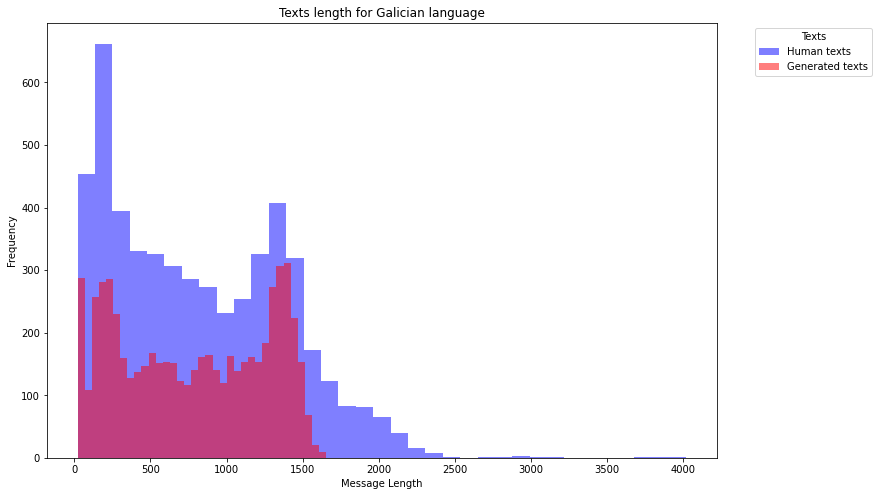

Galician -> Average Human text length: 823.7402823438407
Galician -> Average Computer text length: 782.7481431465226



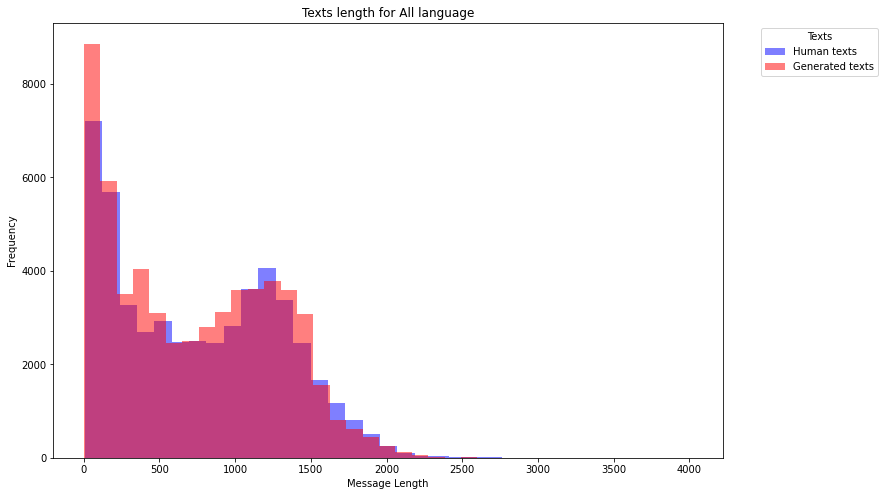

All -> Average Human text length: 761.9570676871562
All -> Average Computer text length: 733.8819454042847



In [38]:
train = [(train_en_preprocessed, 'English'), (train_es_preprocessed, 'Spanish'), (train_pt_preprocessed, 'Portuguese'),
        (train_ca_preprocessed, 'Catalan'), (train_eu_preprocessed, 'Basque'), (train_gl_preprocessed, 'Galician'),
        (train_preprocessed, 'All')]

for train_data, lan in train:
    plot_length(train_data, lan)

### Common words

In [39]:
def plot_common_words(corpus, type, lan):
    if type=='human':
        words = corpus[corpus.label == 0]['clean_text'].apply(lambda x: x.split())
    else:
        words = corpus[corpus.label == 1]['clean_text'].apply(lambda x: x.split())
    

    ham_words= Counter()
    for msg in words:
        ham_words.update(msg)
        
    print(ham_words.most_common(50))
        
    common_words = [word[0] for word in ham_words.most_common(20)]
    word_counts = [word[1] for word in ham_words.most_common(20)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(common_words, word_counts, color='skyblue')
    plt.title(f'Top 20 Most Common Words in {type} {lan} texts Labeled Data')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

[('said', 10414), ('would', 5365), ('one', 5347), ('mr', 3894), ('also', 3593), ('people', 3497), ('first', 3250), ('time', 3052), ('could', 2987), ('like', 2869), ('new', 2869), ('two', 2743), ('well', 2312), ('see', 2214), ('made', 2167), ('years', 2142), ('us', 2130), ('good', 2105), ('may', 2075), ('much', 1938), ('know', 1852), ('last', 1807), ('book', 1795), ('year', 1791), ('many', 1747), ('little', 1718), ('man', 1717), ('say', 1683), ('great', 1663), ('get', 1643), ('come', 1608), ('work', 1587), ('go', 1577), ('make', 1575), ('dont', 1539), ('back', 1536), ('never', 1511), ('way', 1496), ('told', 1495), ('government', 1492), ('day', 1485), ('think', 1466), ('life', 1452), ('found', 1419), ('three', 1405), ('world', 1394), ('since', 1393), ('take', 1387), ('part', 1364), ('must', 1329)]


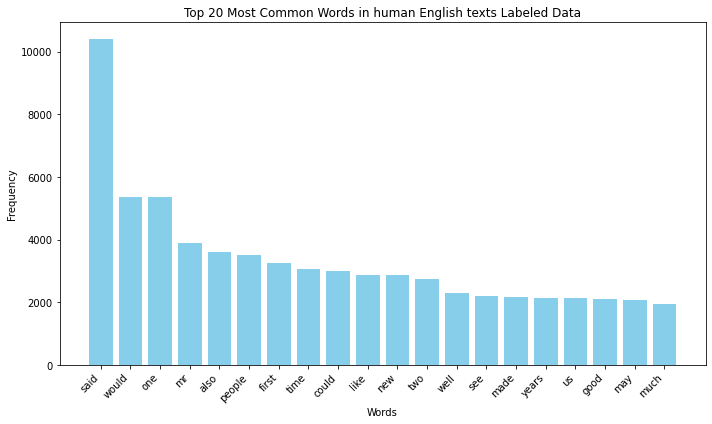

[('also', 9392), ('said', 7364), ('one', 5987), ('would', 5591), ('new', 4661), ('could', 4200), ('time', 4102), ('including', 3599), ('made', 3550), ('people', 3464), ('many', 3382), ('help', 3292), ('life', 3245), ('however', 3220), ('known', 3193), ('like', 3186), ('man', 3149), ('first', 3050), ('world', 3025), ('work', 2971), ('mr', 2772), ('found', 2760), ('years', 2706), ('way', 2669), ('government', 2625), ('several', 2551), ('make', 2500), ('see', 2500), ('couldnt', 2497), ('eyes', 2471), ('local', 2468), ('significant', 2441), ('two', 2422), ('back', 2385), ('home', 2259), ('family', 2193), ('may', 2176), ('despite', 2173), ('city', 2151), ('knew', 2145), ('around', 2139), ('take', 2132), ('community', 2113), ('come', 2085), ('well', 2057), ('day', 2010), ('place', 2004), ('young', 2000), ('face', 1994), ('voice', 1912)]


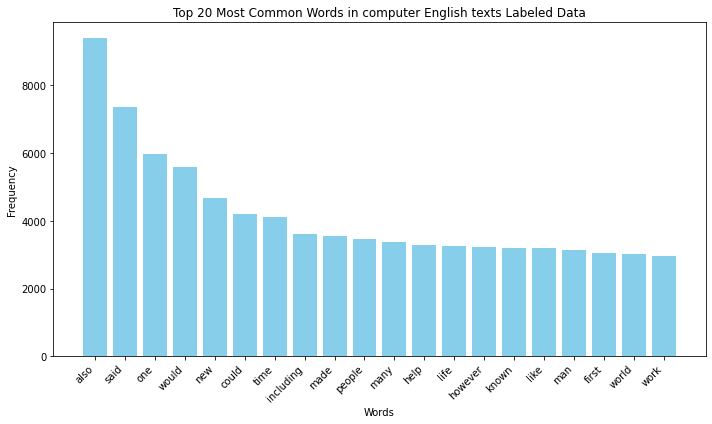

[('si', 4310), ('años', 3548), ('dos', 3098), ('dijo', 2859), ('ser', 2858), ('hotel', 2559), ('vez', 2465), ('después', 2343), ('bien', 2277), ('mundo', 2256), ('final', 2217), ('así', 2073), ('parte', 2061), ('siempre', 1864), ('tiempo', 1831), ('año', 1794), ('tan', 1766), ('sido', 1752), ('solo', 1728), ('ahora', 1701), ('mejor', 1695), ('personas', 1693), ('quizás', 1679), ('país', 1676), ('puede', 1667), ('vida', 1660), ('primera', 1658), ('día', 1629), ('según', 1622), ('gran', 1607), ('servicio', 1600), ('lugar', 1582), ('mismo', 1558), ('cada', 1543), ('casa', 1535), ('mientras', 1534), ('aunque', 1511), ('unidos', 1470), ('hacer', 1447), ('interese', 1446), ('excelente', 1439), ('hace', 1421), ('ciudad', 1418), ('hacia', 1369), ('momento', 1364), ('tres', 1345), ('familia', 1337), ('comida', 1323), ('menos', 1279), ('gobierno', 1277)]


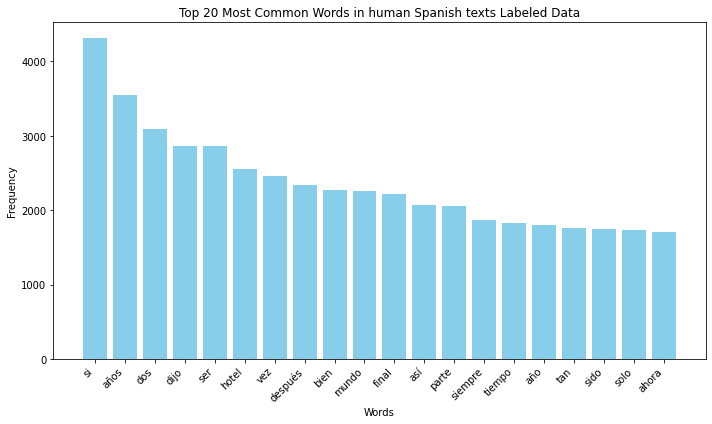

[('ser', 3785), ('sido', 3770), ('hotel', 3287), ('mundo', 2926), ('embargo', 2879), ('ciudad', 2858), ('vida', 2858), ('además', 2691), ('si', 2669), ('puede', 2546), ('siempre', 2478), ('años', 2452), ('momento', 2398), ('mientras', 2356), ('gran', 2355), ('cada', 2305), ('lugar', 2224), ('vez', 2125), ('personal', 2111), ('solo', 2105), ('historia', 2030), ('the', 2015), ('país', 2009), ('después', 1964), ('parte', 1946), ('aunque', 1911), ('día', 1828), ('dijo', 1824), ('pesar', 1785), ('tiempo', 1784), ('personas', 1764), ('habitación', 1703), ('importante', 1684), ('podía', 1653), ('dos', 1647), ('así', 1589), ('ahora', 1479), ('gobierno', 1450), ('hombre', 1443), ('unidos', 1424), ('cuenta', 1424), ('cómo', 1414), ('encuentra', 1400), ('hacia', 1397), ('hacer', 1350), ('pueden', 1335), ('amable', 1313), ('tan', 1304), ('casa', 1288), ('trabajo', 1272)]


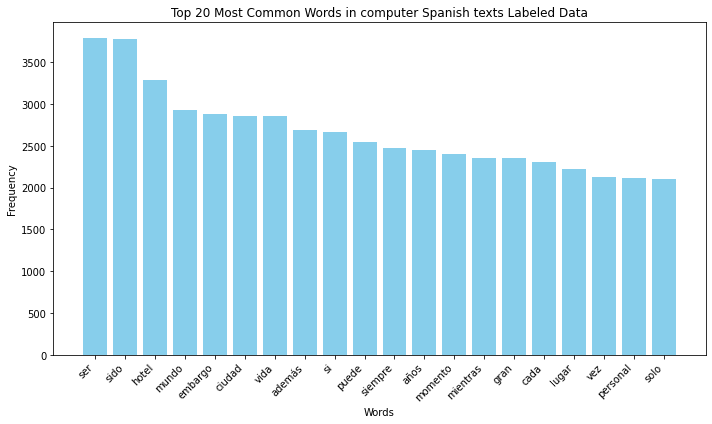

[('disse', 3506), ('ainda', 2962), ('anos', 2791), ('sobre', 2494), ('dois', 1993), ('segundo', 1938), ('brasil', 1926), ('dia', 1885), ('casa', 1883), ('bem', 1818), ('ter', 1778), ('país', 1756), ('onde', 1726), ('tempo', 1718), ('pessoas', 1667), ('governo', 1637), ('vez', 1621), ('todos', 1567), ('pode', 1538), ('então', 1517), ('ano', 1495), ('agora', 1457), ('parte', 1443), ('grande', 1409), ('porque', 1405), ('cidade', 1397), ('estados', 1391), ('vida', 1384), ('havia', 1383), ('presidente', 1370), ('antes', 1366), ('tudo', 1365), ('outros', 1360), ('mundo', 1322), ('durante', 1315), ('pouco', 1305), ('tão', 1295), ('assim', 1284), ('unidos', 1280), ('dias', 1272), ('primeiro', 1263), ('produto', 1261), ('três', 1256), ('contra', 1253), ('desde', 1242), ('apenas', 1236), ('outro', 1231), ('menos', 1214), ('duas', 1209), ('homem', 1202)]


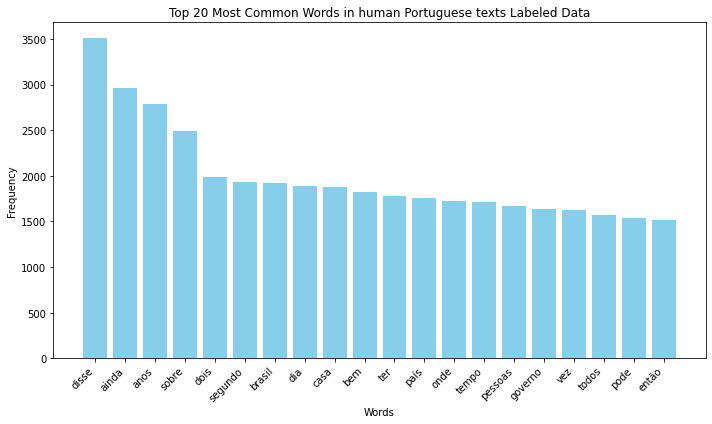

[('ainda', 3802), ('sobre', 3492), ('vida', 3096), ('cidade', 2894), ('além', 2826), ('pode', 2414), ('país', 2382), ('mundo', 2290), ('onde', 2251), ('havia', 2124), ('disso', 2105), ('enquanto', 2073), ('entanto', 2054), ('anos', 2022), ('história', 2008), ('cada', 1953), ('disse', 1950), ('apenas', 1912), ('ter', 1873), ('sempre', 1855), ('pessoas', 1849), ('homem', 1836), ('tempo', 1816), ('desde', 1780), ('sido', 1764), ('região', 1755), ('vez', 1749), ('durante', 1732), ('todos', 1724), ('grande', 1662), ('tudo', 1641), ('bem', 1612), ('produto', 1589), ('the', 1562), ('após', 1532), ('sabia', 1531), ('brasil', 1521), ('casa', 1507), ('outros', 1486), ('dia', 1439), ('importante', 1430), ('tão', 1430), ('olhos', 1401), ('momento', 1386), ('sendo', 1376), ('agora', 1374), ('fazer', 1371), ('governo', 1339), ('então', 1318), ('assim', 1286)]


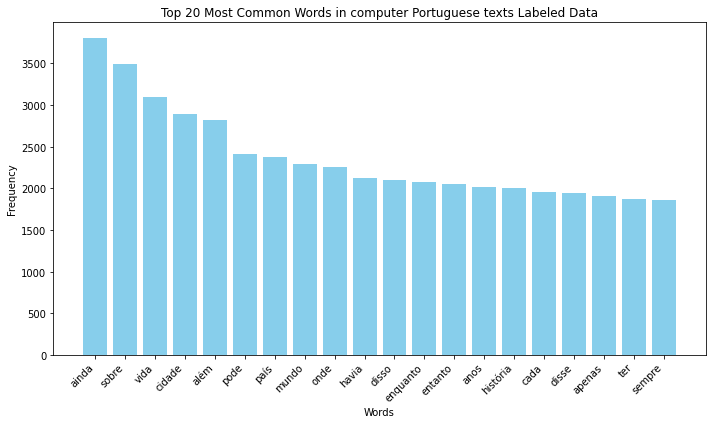

[('anys', 1721), ('catalunya', 1575), ('segons', 1560), ('persones', 1477), ('cap', 1386), ('govern', 1378), ('sha', 1304), ('barcelona', 1295), ('dun', 1219), ('dos', 1184), ('part', 1176), ('referències', 1126), ('fet', 1109), ('duna', 1102), ('lany', 1083), ('població', 1058), ('té', 983), ('gran', 947), ('president', 906), ('fou', 897), ('tres', 861), ('ciutat', 831), ('pot', 792), ('lestat', 789), ('se', 783), ('dues', 779), ('ara', 744), ('y', 717), ('família', 717), ('espanyol', 708), ('lo', 697), ('primera', 694), ('shan', 678), ('sant', 673), ('nou', 626), ('nom', 609), ('generalitat', 608), ('grup', 597), ('nova', 597), ('habitatges', 597), ('dia', 582), ('lloc', 578), ('tenia', 574), ('dones', 569), ('passat', 562), ('dit', 555), ('banda', 554), ('daquest', 554), ('forma', 545), ('general', 541)]


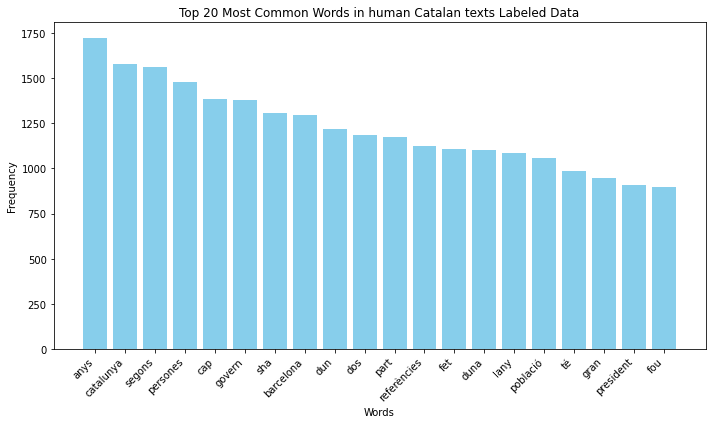

[('catalunya', 2592), ('gran', 2509), ('ara', 2271), ('govern', 2225), ('vida', 2191), ('té', 1921), ('ciutat', 1906), ('dun', 1823), ('barcelona', 1729), ('cap', 1661), ('part', 1476), ('segons', 1456), ('món', 1421), ('pot', 1378), ('català', 1354), ('fet', 1348), ('sha', 1342), ('anys', 1305), ('the', 1294), ('temps', 1268), ('lloc', 1263), ('història', 1256), ('poble', 1148), ('president', 1125), ('nit', 1091), ('catalana', 1050), ('duna', 1044), ('dia', 1039), ('cor', 1024), ('persones', 1014), ('sempre', 973), ('lany', 938), ('partit', 920), ('diverses', 916), ('diferents', 899), ('shan', 889), ('important', 882), ('terra', 875), ('generalitat', 861), ('zona', 845), ('situació', 837), ('mai', 829), ('amor', 829), ('dir', 826), ('dos', 819), ('segle', 814), ('troba', 810), ('sol', 796), ('política', 785), ('moment', 784)]


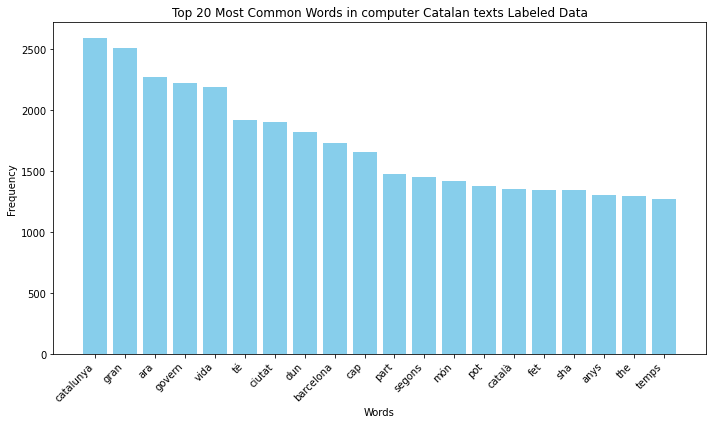

[('zeuden', 2087), ('egiten', 1743), ('bi', 1621), ('izango', 1585), ('behar', 1562), ('nahi', 1507), ('zituzten', 1459), ('kanpo', 1266), ('dut', 1151), ('estekak', 1150), ('zion', 1118), ('euskal', 1096), ('duen', 1070), ('ari', 1062), ('oso', 1019), ('pertsona', 1010), ('gainera', 972), ('gehiago', 954), ('nire', 949), ('etxek', 903), ('bizi', 902), ('hartu', 897), ('zegoen', 883), ('eman', 850), ('urte', 848), ('hiru', 847), ('etxebizitza', 830), ('diren', 825), ('gure', 802), ('zela', 800), ('lan', 787), ('joan', 775), ('duten', 744), ('egiteko', 735), ('bakarrik', 723), ('a', 713), ('2007an', 711), ('azken', 694), ('de', 690), ('nuen', 675), ('gizon', 667), ('erreferentziak', 657), ('dugu', 648), ('ezin', 647), ('1', 630), ('bertan', 623), ('bigarren', 608), ('hainbat', 607), ('biztanle', 606), ('emakume', 592)]


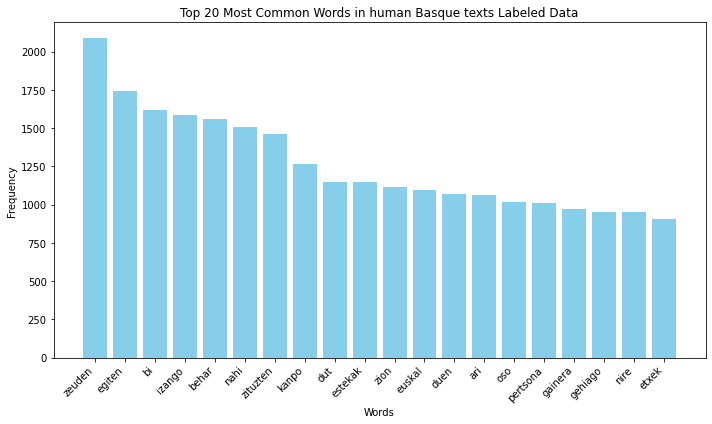

[('gure', 4552), ('euskal', 4349), ('izango', 3810), ('duen', 2873), ('nire', 2713), ('behar', 2597), ('egiten', 2378), ('hainbat', 2288), ('nahi', 2277), ('duzu', 2079), ('ezagutzen', 2051), ('oso', 1940), ('eman', 1794), ('dugu', 1671), ('dut', 1667), ('bilboko', 1662), ('bi', 1652), ('daude', 1617), ('duten', 1587), ('gehiago', 1529), ('zehar', 1413), ('ezin', 1412), ('aukera', 1399), ('herriko', 1395), ('bertan', 1376), ('dituen', 1298), ('dituzte', 1282), ('ematen', 1233), ('azken', 1204), ('euskara', 1201), ('dakit', 1162), ('buruzko', 1121), ('diren', 1066), ('gora', 1047), ('zure', 1042), ('lan', 1039), ('parte', 1023), ('hartu', 1004), ('beti', 908), ('izena', 894), ('kultura', 892), ('handia', 887), ('ahal', 887), ('bakarrik', 884), ('arteko', 881), ('hiru', 878), ('dagoen', 873), ('nuen', 869), ('ari', 868), ('eusko', 864)]


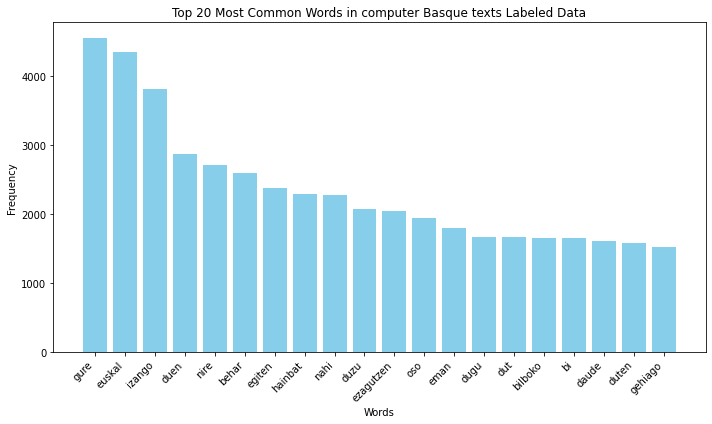

[('é', 6798), ('como', 5584), ('máis', 4089), ('súa', 3782), ('tamén', 3151), ('á', 3103), ('entre', 1722), ('son', 1631), ('lugares', 1496), ('ano', 1493), ('concello', 1444), ('está', 1389), ('xa', 1359), ('anos', 1325), ('lugar', 1193), ('galicia', 1183), ('ás', 1151), ('parte', 1072), ('parroquias', 1038), ('todo', 1034), ('así', 1018), ('onde', 996), ('outros', 968), ('súas', 952), ('segundo', 948), ('galego', 938), ('véxase', 925), ('durante', 922), ('aínda', 907), ('notas', 879), ('ata', 854), ('parroquia', 850), ('despois', 801), ('dende', 791), ('mesmo', 783), ('sen', 769), ('ó', 767), ('primeira', 758), ('dous', 751), ('cidade', 749), ('só', 731), ('historia', 730), ('día', 730), ('primeiro', 724), ('nome', 677), ('todos', 677), ('dúas', 672), ('persoas', 669), ('tiña', 640), ('cada', 634)]


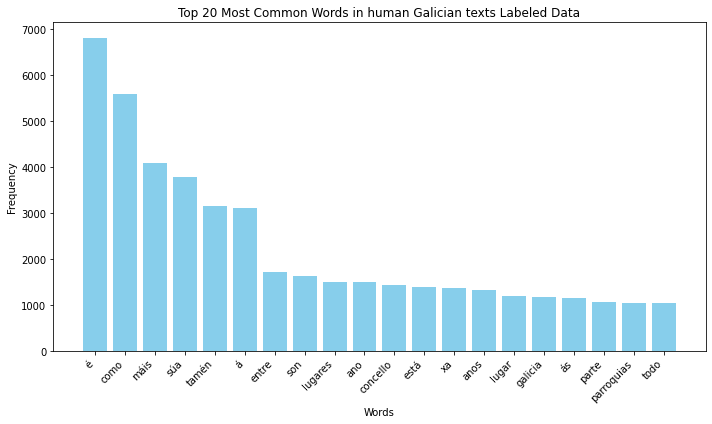

[('é', 12040), ('súa', 7084), ('como', 6477), ('máis', 5191), ('tamén', 3608), ('á', 3050), ('está', 2409), ('galicia', 2359), ('son', 2301), ('entre', 1928), ('historia', 1729), ('cada', 1669), ('durante', 1596), ('súas', 1576), ('vida', 1544), ('ademais', 1543), ('galega', 1473), ('lugar', 1472), ('onde', 1464), ('concello', 1409), ('así', 1375), ('sen', 1336), ('todos', 1316), ('só', 1314), ('parroquia', 1254), ('xa', 1215), ('todo', 1210), ('galego', 1190), ('cultura', 1174), ('cidade', 1163), ('día', 1158), ('ano', 1158), ('importante', 1157), ('parte', 1147), ('mundo', 1137), ('ás', 1123), ('gran', 1116), ('anos', 1097), ('aínda', 1027), ('traballo', 1020), ('nova', 939), ('tempo', 908), ('século', 886), ('san', 821), ('zona', 819), ('están', 810), ('senón', 795), ('provincia', 784), ('sempre', 783), ('desta', 780)]


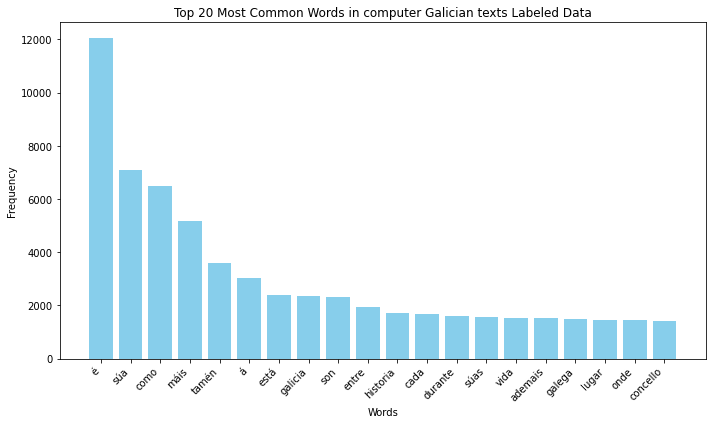

[('said', 10432), ('é', 6830), ('como', 5599), ('one', 5469), ('would', 5367), ('si', 5265), ('parte', 5059), ('vez', 4713), ('casa', 4292), ('dos', 4291), ('país', 4288), ('mundo', 4156), ('anos', 4120), ('máis', 4089), ('mr', 4007), ('vida', 3921), ('súa', 3783), ('final', 3633), ('also', 3594), ('años', 3562), ('people', 3523), ('disse', 3506), ('1', 3499), ('segundo', 3441), ('lugar', 3369), ('new', 3359), ('á', 3321), ('first', 3288), ('time', 3267), ('gran', 3198), ('tamén', 3155), ('2', 3097), ('así', 3093), ('cada', 3081), ('unidos', 3028), ('forma', 3012), ('ano', 2994), ('ainda', 2994), ('the', 2993), ('could', 2991), ('bbc', 2920), ('presidente', 2919), ('like', 2917), ('hotel', 2908), ('ser', 2871), ('tres', 2869), ('menos', 2868), ('dijo', 2859), ('two', 2769), ('onde', 2722)]


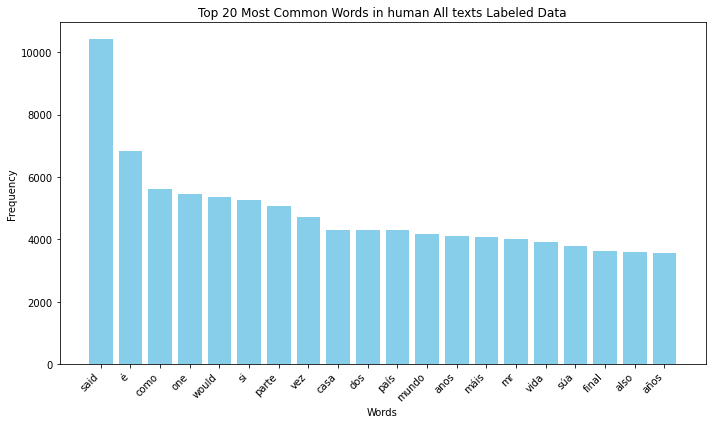

[('é', 12082), ('vida', 9736), ('also', 9557), ('said', 7410), ('súa', 7110), ('como', 6498), ('mundo', 6365), ('one', 6156), ('gran', 5992), ('cada', 5928), ('the', 5770), ('would', 5714), ('país', 5558), ('sido', 5537), ('parte', 5215), ('máis', 5197), ('new', 4998), ('local', 4742), ('lugar', 4596), ('vez', 4564), ('gure', 4553), ('euskal', 4353), ('historia', 4351), ('time', 4337), ('importante', 4274), ('could', 4247), ('momento', 4217), ('cidade', 4060), ('ainda', 3942), ('izango', 3810), ('ser', 3798), ('onde', 3722), ('hotel', 3711), ('casa', 3699), ('forma', 3676), ('including', 3658), ('tamén', 3617), ('sempre', 3611), ('made', 3599), ('people', 3585), ('sobre', 3494), ('many', 3443), ('si', 3411), ('man', 3371), ('durante', 3357), ('help', 3353), ('life', 3338), ('like', 3319), ('part', 3299), ('known', 3271)]


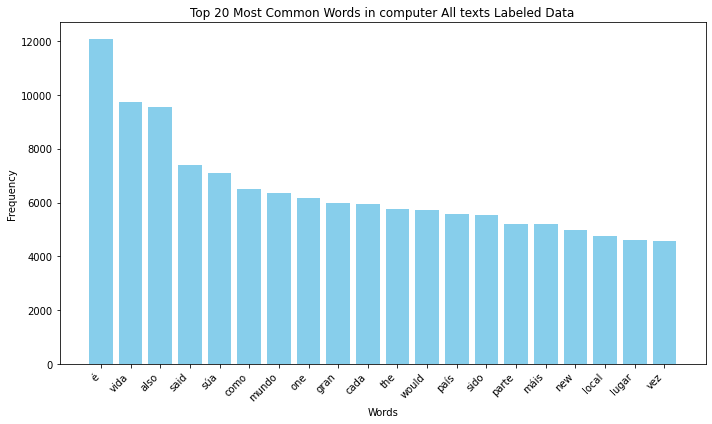

In [40]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10

for train_data, lan in train:
    plot_common_words(train_data, 'human', lan)
    plot_common_words(train_data, 'computer', lan)


## Validation

In [44]:
def train_test(corpus, test):
    x_train, x_test, y_train, y_test = train_test_split(corpus.loc[:'clean_text'],
                                                       corpus['label'], test_size=test, random_state=42)
    print("Dimensions of Training subset")
    print(x_train.shape)
    print(x_test.shape)
    
    print("Dimensions of Testing subset")
    print(y_train.shape)
    print(y_test.shape)
    print()
          
    return x_train['clean_text'], x_test['clean_text'], y_train, y_test

In [52]:
x_train_en, x_test_en, y_train_en, y_test_en = train_test(train_en_preprocessed, 0.2)
x_train_es, x_test_es, y_train_es, y_test_es = train_test(train_es_preprocessed, 0.2)
x_train_ca, x_test_ca, y_train_ca, y_test_ca = train_test(train_ca_preprocessed, 0.2)
x_train_eu, x_test_eu, y_train_eu, y_test_eu = train_test(train_eu_preprocessed, 0.2)
x_train_gl, x_test_gl, y_train_gl, y_test_gl = train_test(train_gl_preprocessed, 0.2)
x_train_pt, x_test_pt, y_train_pt, y_test_pt = train_test(train_pt_preprocessed, 0.2)


Dimensions of Training subset
(20561, 6)
(5141, 6)
Dimensions of Testing subset
(20561,)
(5141,)

Dimensions of Training subset
(17695, 6)
(4424, 6)
Dimensions of Testing subset
(17695,)
(4424,)

Dimensions of Training subset
(12956, 6)
(3239, 6)
Dimensions of Testing subset
(12956,)
(3239,)

Dimensions of Training subset
(10735, 6)
(2684, 6)
Dimensions of Testing subset
(10735,)
(2684,)

Dimensions of Training subset
(8876, 6)
(2219, 6)
Dimensions of Testing subset
(8876,)
(2219,)

Dimensions of Training subset
(15617, 6)
(3905, 6)
Dimensions of Testing subset
(15617,)
(3905,)



In [46]:
x_train, x_test, y_train, y_test = train_test_split(train_preprocessed['clean_text'],
                                                   train_preprocessed['label'], test_size=0.2, random_state=42)
print("Dimensions of Training subset")
print(x_train.shape)
print(x_test.shape)

print("Dimensions of Testing subset")
print(y_train.shape)
print(y_test.shape)
print()


Dimensions of Training subset
(86441,)
(21611,)
Dimensions of Testing subset
(86441,)
(21611,)



## Minable view

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Bag of Words

vect = CountVectorizer()

# Bag of Words (Term-frequency)
## Represent the text considering the term frequency of words
### considering the frequency of the terms (binary=False), and removing stopwords (stop_words="english")

term_frequency = CountVectorizer(binary=False)


# Bigrams of Words (Term-Frequency)
## Represent the text considering the frequency of pairs of adjacent words.
### considering the frequency of the bigrams of words (binary=False), and removing stopwords (stop_words="english")

two_gram_tf = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=False)


# TF-IDF
tfidf_vectorizer = TfidfVectorizer()

In [55]:

def text_representations(train_corpus, test_corpus, model):
    # Learn training data vocabulary, then use it to create a document-term matrix
    x_train_tr = model.fit_transform(train_corpus)
    
    # Examine the document-term matrix
    print("Training document-term matrix:")
    print("Shape:", x_train_tr.shape)
    print("Density:", x_train_tr.nnz / (x_train_tr.shape[0] * x_train_tr.shape[1]))
    
    vocab_size = len(model.vocabulary_)
    print("Vocabulary size:", vocab_size)
    
    # Transform testing data (using fitted vocabulary) into a document-term matrix
    x_test_tr = model.transform(test_corpus)
    
    print("\nTesting document-term matrix:")
    print("Shape:", x_test_tr.shape)
    print("Density:", x_test_tr.nnz / (x_test_tr.shape[0] * x_test_tr.shape[1]))
    print("=======")
    return x_train_tr, x_test_tr


#### Bag of words

In [56]:
print('English')
x_train_v_en, x_test_v_en = text_representations(x_train_en, x_test_en, vect)
print('Spanish')
x_train_v_es, x_test_v_es = text_representations(x_train_es, x_test_es, vect)
print('Catalan')
x_train_v_ca, x_test_v_ca = text_representations(x_train_ca, x_test_ca, vect)
print('Portuguese')
x_train_v_pt, x_test_v_pt = text_representations(x_train_pt, x_test_pt, vect)
print('Basque')
x_train_v_eu, x_test_v_eu = text_representations(x_train_eu, x_test_eu, vect)
print('Galician')
x_train_v_gl, x_test_v_gl = text_representations(x_train_gl, x_test_gl, vect)

English
Training document-term matrix:
Shape: (20561, 107959)
Density: 0.0007732919775799887
Vocabulary size: 107959

Testing document-term matrix:
Shape: (5141, 107959)
Density: 0.0007409157516606705
Spanish
Training document-term matrix:
Shape: (17695, 118026)
Density: 0.0006585978988916034
Vocabulary size: 118026

Testing document-term matrix:
Shape: (4424, 118026)
Density: 0.0006381535940727683
Catalan
Training document-term matrix:
Shape: (12956, 96832)
Density: 0.0005836745070559627
Vocabulary size: 96832

Testing document-term matrix:
Shape: (3239, 96832)
Density: 0.0005269436520822829
Portuguese
Training document-term matrix:
Shape: (15617, 109643)
Density: 0.0007075762005600659
Vocabulary size: 109643

Testing document-term matrix:
Shape: (3905, 109643)
Density: 0.000672128983667083
Basque
Training document-term matrix:
Shape: (10735, 125708)
Density: 0.0005167815658852553
Vocabulary size: 125708

Testing document-term matrix:
Shape: (2684, 125708)
Density: 0.00045470917699793

In [50]:
x_train_v, x_test_v =. text_representations(x_train, x_test, vect)

Training document-term matrix:
Shape: (86441, 496912)
Density: 0.00014995617293762578
Vocabulary size: 496912

Testing document-term matrix:
Shape: (21611, 496912)
Density: 0.0001437061865736111


#### TF-IDF

In [57]:
x_train_tfidf_en, x_test_tfidf_en = text_representations(x_train_en, x_test_en, tfidf_vectorizer)
x_train_tfidf_es, x_test_tfidf_es = text_representations(x_train_es, x_test_es, tfidf_vectorizer)
x_train_tfidf_ca, x_test_tfidf_ca = text_representations(x_train_ca, x_test_ca, tfidf_vectorizer)
x_train_tfidf_pt, x_test_tfidf_pt = text_representations(x_train_pt, x_test_pt, tfidf_vectorizer)
x_train_tfidf_eu, x_test_tfidf_eu = text_representations(x_train_eu, x_test_eu, tfidf_vectorizer)
x_train_tfidf_gl, x_test_tfidf_gl = text_representations(x_train_gl, x_test_gl, tfidf_vectorizer)

Training document-term matrix:
Shape: (20561, 107959)
Density: 0.0007732919775799887
Vocabulary size: 107959

Testing document-term matrix:
Shape: (5141, 107959)
Density: 0.0007409157516606705
Training document-term matrix:
Shape: (17695, 118026)
Density: 0.0006585978988916034
Vocabulary size: 118026

Testing document-term matrix:
Shape: (4424, 118026)
Density: 0.0006381535940727683
Training document-term matrix:
Shape: (12956, 96832)
Density: 0.0005836745070559627
Vocabulary size: 96832

Testing document-term matrix:
Shape: (3239, 96832)
Density: 0.0005269436520822829
Training document-term matrix:
Shape: (15617, 109643)
Density: 0.0007075762005600659
Vocabulary size: 109643

Testing document-term matrix:
Shape: (3905, 109643)
Density: 0.000672128983667083
Training document-term matrix:
Shape: (10735, 125708)
Density: 0.0005167815658852553
Vocabulary size: 125708

Testing document-term matrix:
Shape: (2684, 125708)
Density: 0.00045470917699793673
Training document-term matrix:
Shape: 

## Models and evaluation

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score

logreg = LogisticRegression(solver='liblinear')

In [59]:
def train_test_model(model, x_train, y_train, x_test, y_test):
    %time model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)[:1]
    
    # calculate accuracy of class predictions
    print("=======Accuracy Score===========")
    print(metrics.accuracy_score(y_test, y_test_pred))

    # print the confusion matrix
    print("=======Confusion Matrix===========")
    print(metrics.confusion_matrix(y_test, y_test_pred))

    # calculate AUC
    print("=======ROC AUC Score===========")
    print(metrics.roc_auc_score(y_test, y_test_pred))

    print(f"F1-score for Logistic Regression model: {f1_score(y_test, y_test_pred, average='macro')}")
    print()

### Logistic regresion

In [61]:
print('English')
train_test_model(logreg, x_train_v_en, y_train_en, x_test_v_en, y_test_en)

print('Spanish')
train_test_model(logreg, x_train_v_es, y_train_es, x_test_v_es, y_test_es)

print('Portuguese')
train_test_model(logreg, x_train_v_pt, y_train_pt, x_test_v_pt, y_test_pt)

print('Catalan')
train_test_model(logreg, x_train_v_ca, y_train_ca, x_test_v_ca, y_test_ca)

print('Basque')
train_test_model(logreg, x_train_v_eu, y_train_eu, x_test_v_eu, y_test_eu)

print('Galician')
train_test_model(logreg, x_train_v_gl, y_train_gl, x_test_v_gl, y_test_gl)

print('General')
train_test_model(logreg, x_train_v, y_train, x_test_v, y_test)

English
Wall time: 1.92 s
=======Accuracy Score===========
0.859754911495818
=======Confusion Matrix===========
[[1980  369]
 [ 352 2440]]
=======ROC AUC Score===========
0.8584186894136504
F1-score for Logistic Regression model: 0.8586230348206276

Spanish
Wall time: 1.34 s
=======Accuracy Score===========
0.8883363471971067
=======Confusion Matrix===========
[[2063  253]
 [ 241 1867]]
=======ROC AUC Score===========
0.8882167776018982
F1-score for Logistic Regression model: 0.8881167397723689

Portuguese
Wall time: 1.5 s
=======Accuracy Score===========
0.8670934699103713
=======Confusion Matrix===========
[[1818  236]
 [ 283 1568]]
=======ROC AUC Score===========
0.8661059549905127
F1-score for Logistic Regression model: 0.8665464943428467

Catalan
Wall time: 851 ms
=======Accuracy Score===========
0.853349799320778
=======Confusion Matrix===========
[[ 978  315]
 [ 160 1786]]
=======ROC AUC Score===========
0.8370802860528944
F1-score for Logistic Regression model: 0.84361813276477